In [1]:
import gasinvert.atmospheric_measurements as gp
import gasinvert.mcmc as mcmc

from jax.flatten_util import ravel_pytree
import matplotlib.pylab as pylab
import jax.numpy as jnp
from jax import config
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import numpy as np
import pickle
import optax
import jax
import time

config.update("jax_enable_x64", True)
params = {
        'legend.fontsize': '15',
        'axes.labelsize': '20',
        'axes.titlesize': '30',
        'xtick.labelsize':'x-large',
        'ytick.labelsize':'x-large',
        'figure.figsize': '10, 7',
        }
pylab.rcParams.update(params)

### 1. Simulating Atmospheric Conditions and Sensors locations

In [2]:
# Make a grid
grid = gp.Grid(
    x_range = (jnp.array(0.0), jnp.array(120.0)), 
    y_range = (jnp.array(0.0), jnp.array(120.0)),
    z_range= (jnp.array(0.0), jnp.array(0.0)),
    dx = jnp.array(40),
    dy = jnp.array(40),
    dz = jnp.array(40),
)

# Choose a source location
source_location = gp.SourceLocation(
    source_location_x = jnp.array(60.0),
    source_location_y = jnp.array(60.0),
    source_location_z = jnp.array(10.0),
)

# Define the wind field
wind_field = gp.WindField(
    initial_wind_speed = jnp.array(10.0),
    initial_wind_direction = jnp.array(0.0),
    threesixty_degrees= True,
    number_of_time_steps = jnp.array(1_000),
    time_step = jnp.array(1.0),
    wind_speed_temporal_std = jnp.array(0.5),
    wind_direction_temporal_std = jnp.array(30.0),
    wind_temporal_correlation = jnp.array(0.1),
    wind_speed_seed = 2,
    wind_direction_seed = 4,
)

# Define an atmospheric state settings
atmospheric_state = gp.AtmosphericState(
    vertical_angle = jnp.deg2rad(jnp.array(25.0)),
    horizontal_angle = jnp.deg2rad(jnp.array(20.0)),
    emission_rate = jnp.array(1.6e-3),      
    half_width = jnp.array(2.0),
    max_abl = jnp.array(1000.0),
    background_mean = jnp.array(1.9),       
    background_std = jnp.array(1e-4),       
    background_seed = jnp.array(56),
    background_filter = "power-law",        
    Gaussian_filter_kernel = 1,              
    downwind_power_H = jnp.array(1.0),         
    downwind_power_V = jnp.array(0.75),         
)

# Define sensor settings
sensors_settings =  gp.SensorsSettings(
    sensor_number = jnp.array(25),
    measurement_error_var = jnp.array(1e-3),
    measurement_elevation = jnp.array(0.0),
    sensor_seed = jnp.array(5),
    measurement_error_seed = jnp.array(420),
    sensor_locations =  [[10,0,20], [10, 40, 20], [10,80,20], [10, 120, 20], [10, 160, 20],
                            [120,0,40], [120, 40, 40], [120,80,40], [120, 120, 40], [120, 160, 40],
                            [10,0,80], [10, 40, 80], [10,80,80], [10, 120, 80], [10, 160, 80],
                            [120,0,120], [120, 40, 120], [120,80,120], [120, 120, 120], [120, 160, 120],
                            [90,20,30], [40,125,80], [80, 80, 80], [10,10,10], [40,125,40]]
)


save = False

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


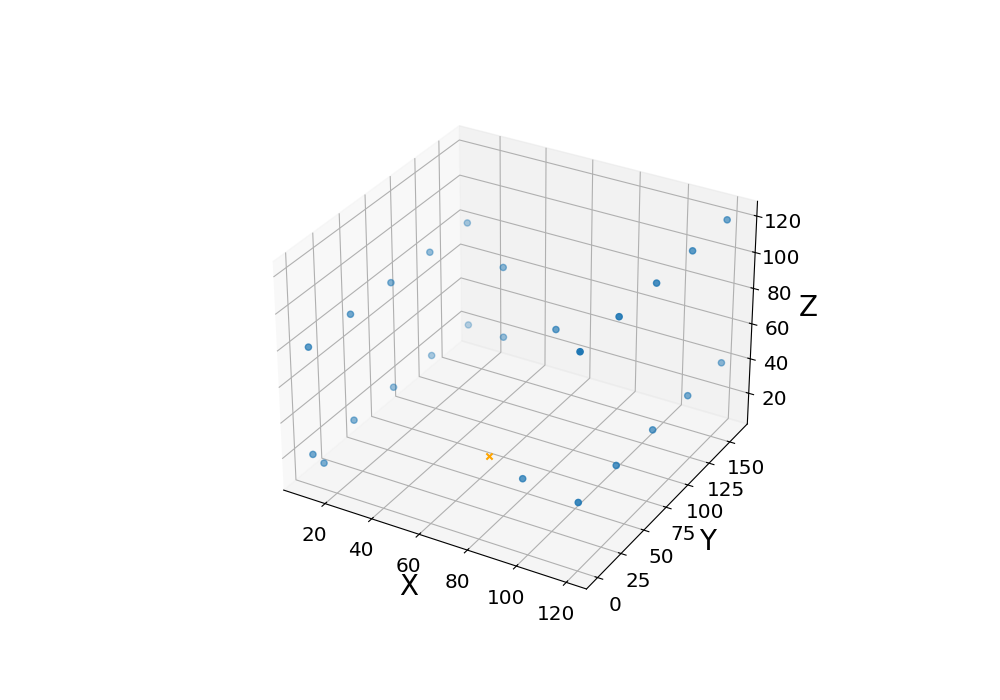

In [3]:
# for creating a responsive plot
%matplotlib widget
import matplotlib.pyplot as plt


# Extract sensor locations
sensor_locations = sensors_settings.sensor_locations

# Create a new figure
fig = plt.figure()

# Create a 3D subplot

ax = fig.add_subplot(111, projection='3d')

# Extract x, y, z coordinates
x_coords = [location[0] for location in sensor_locations]
y_coords = [location[1] for location in sensor_locations]
z_coords = [location[2] for location in sensor_locations]

# Plot the sensor locations
ax.scatter(x_coords, y_coords, z_coords)
extra_point = (source_location.source_location_x, source_location.source_location_y, source_location.source_location_z)
ax.scatter(*extra_point, color='orange', marker='x')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()
%matplotlib inline

#### 1.1 Gaussian plume Class 

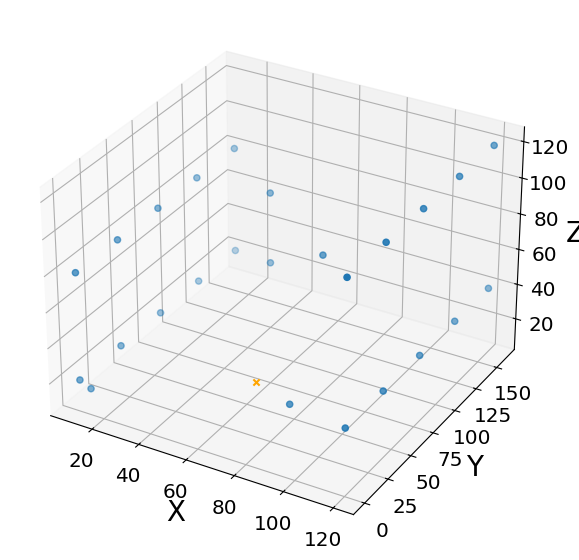

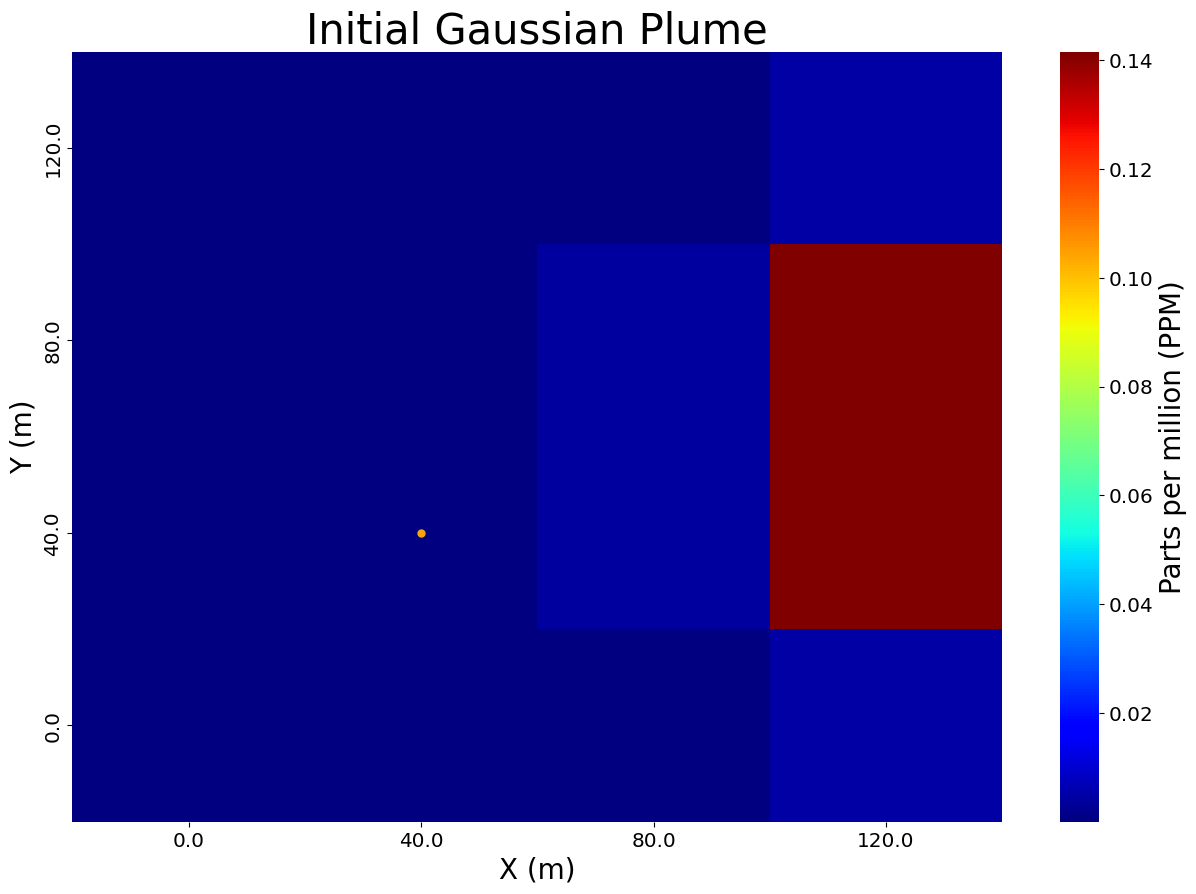

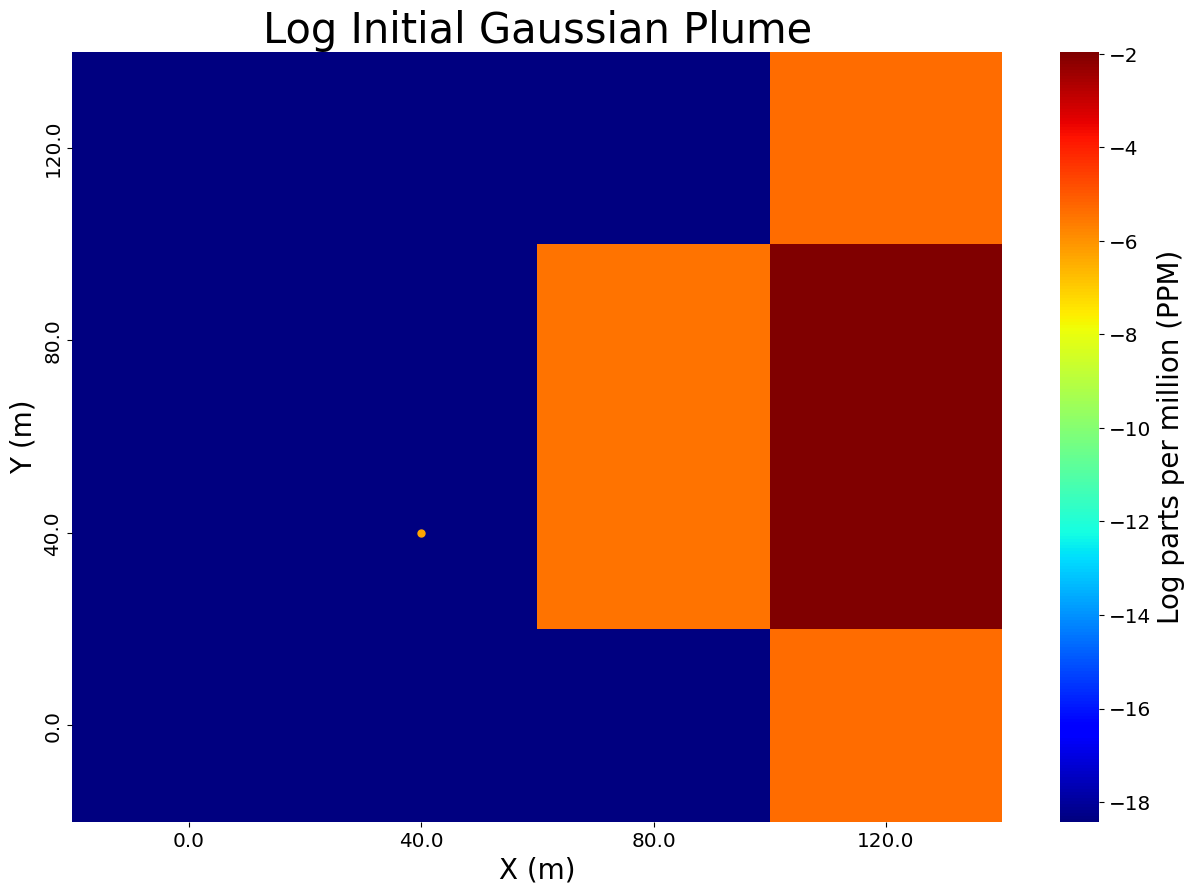

No such comm: b94b0e1b279f415482e33ff09fad8098
No such comm: b94b0e1b279f415482e33ff09fad8098
No such comm: b94b0e1b279f415482e33ff09fad8098
No such comm: b94b0e1b279f415482e33ff09fad8098
No such comm: b94b0e1b279f415482e33ff09fad8098
No such comm: b94b0e1b279f415482e33ff09fad8098
No such comm: b94b0e1b279f415482e33ff09fad8098
No such comm: b94b0e1b279f415482e33ff09fad8098
No such comm: b94b0e1b279f415482e33ff09fad8098
No such comm: b94b0e1b279f415482e33ff09fad8098
No such comm: b94b0e1b279f415482e33ff09fad8098


In [4]:
gaussianplume = gp.GaussianPlume(grid, source_location, wind_field, atmospheric_state, sensors_settings)
gaussianplume.initial_gaussian_plume_plot(save, format='png')
gaussianplume.log_initial_gaussian_plume_plot(save, format='png')


#### 1.2 Background concentration Class

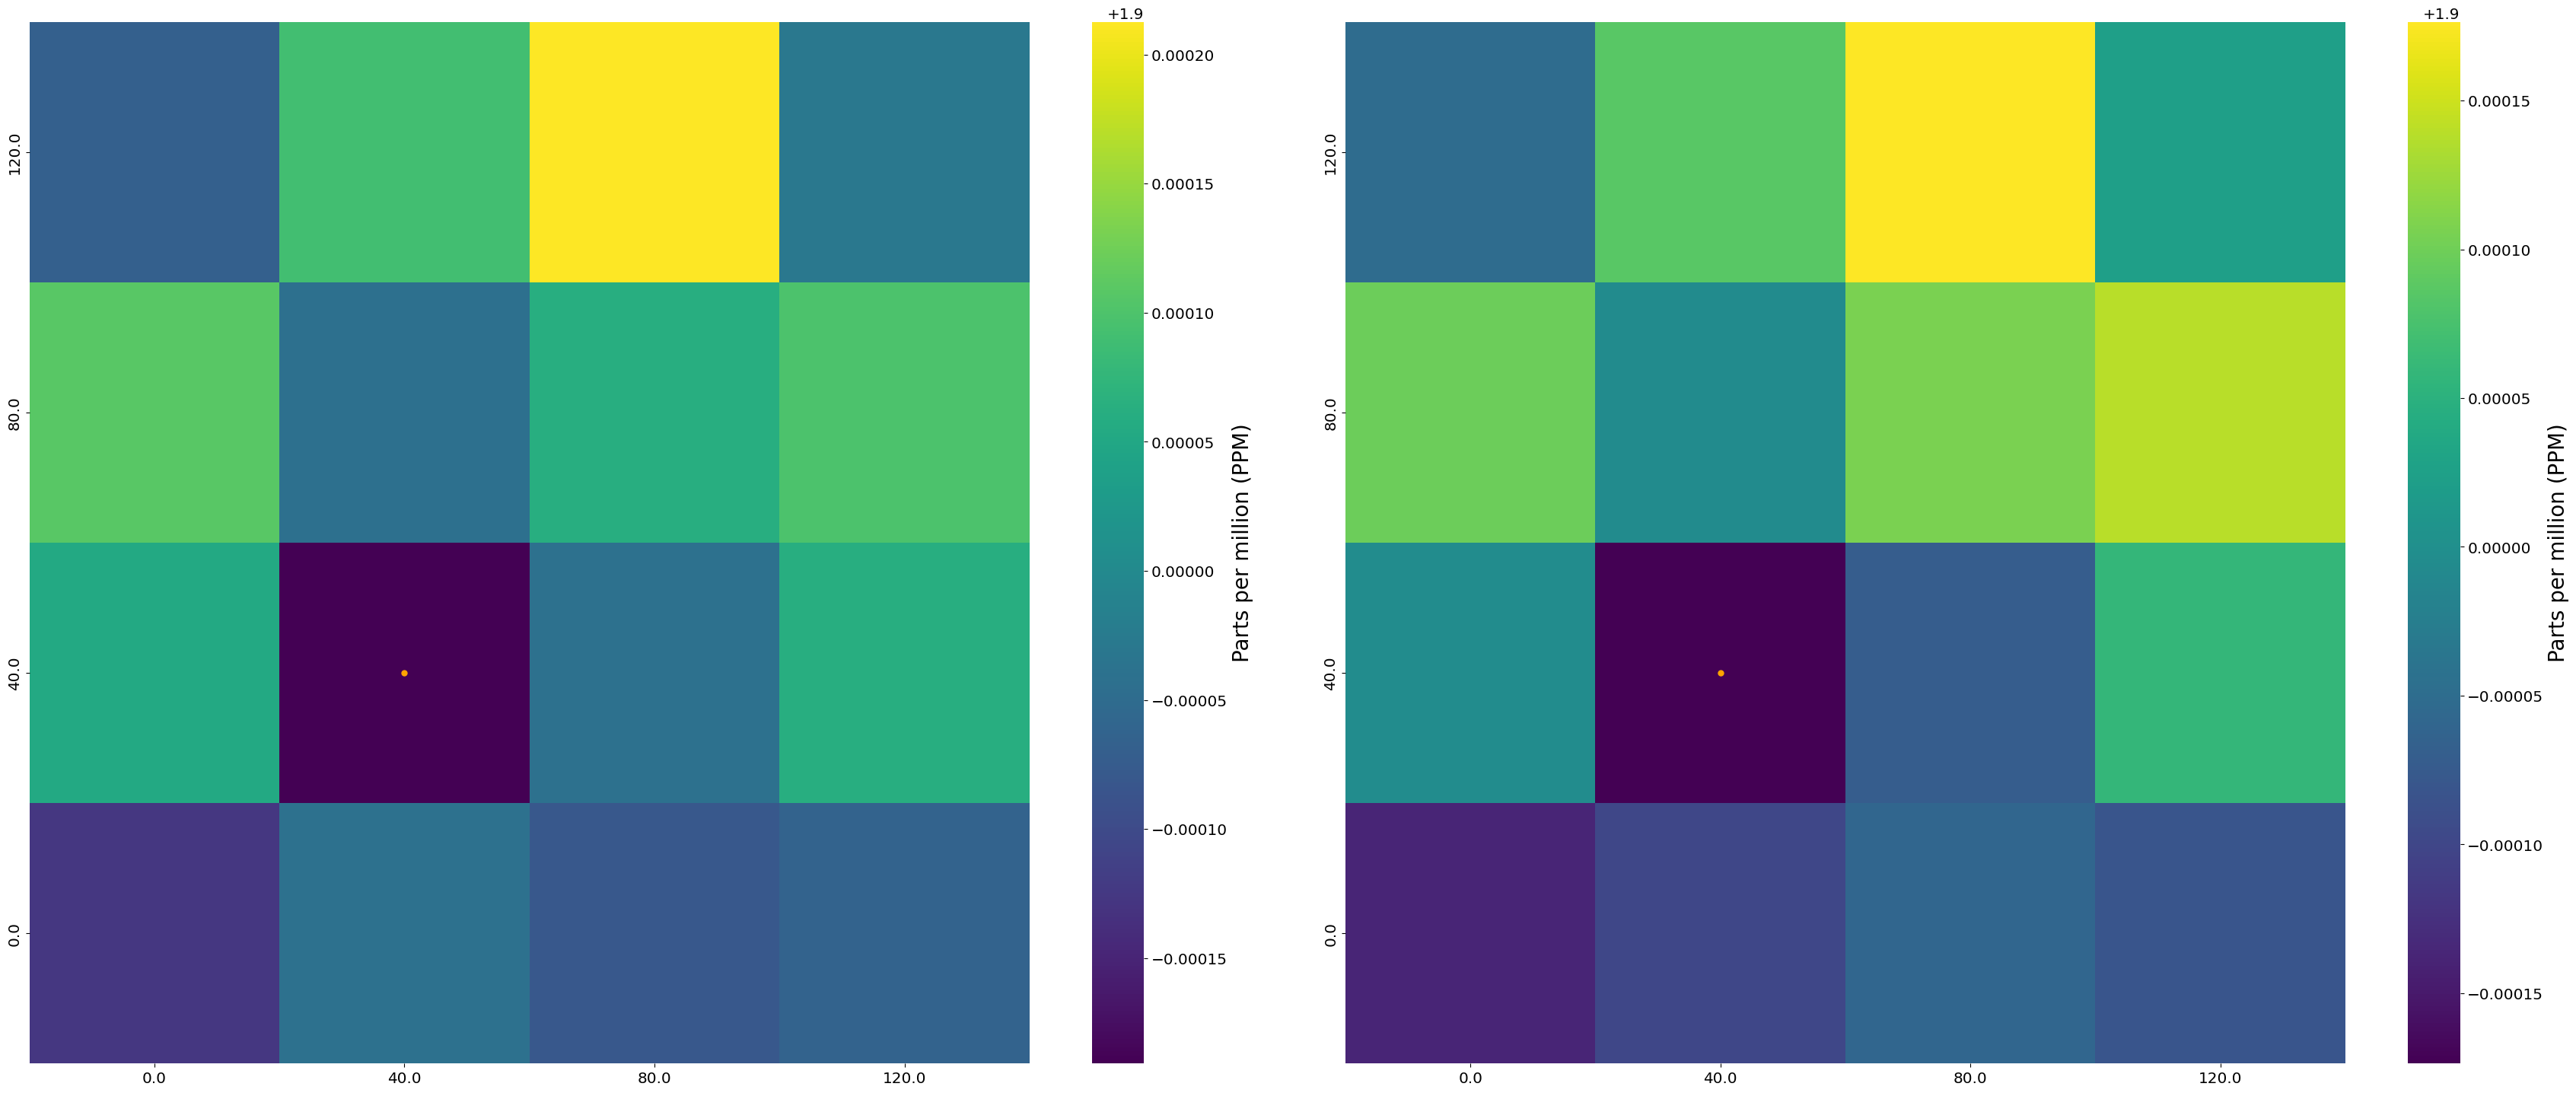

In [5]:
background = gp.BackgroundGas(grid, source_location, atmospheric_state)
background.background_plot(save, format='jpeg')


#### 1.3 Changing wind speed and direction

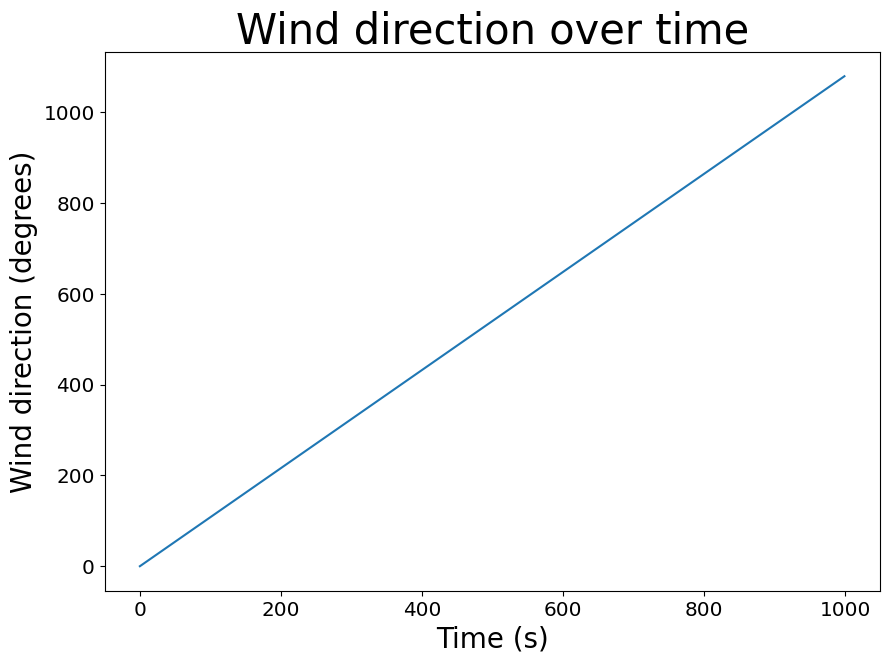

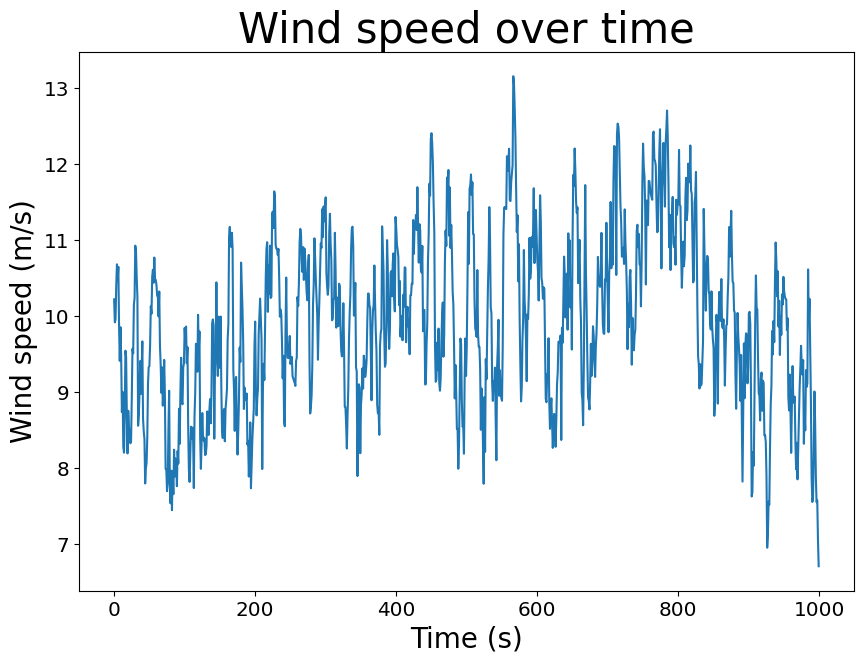

In [6]:
gaussianplume.wind_direction_plot(save, format='png')
gaussianplume.wind_speed_plot(save, format='png')


#### 1.4 Sensors Class

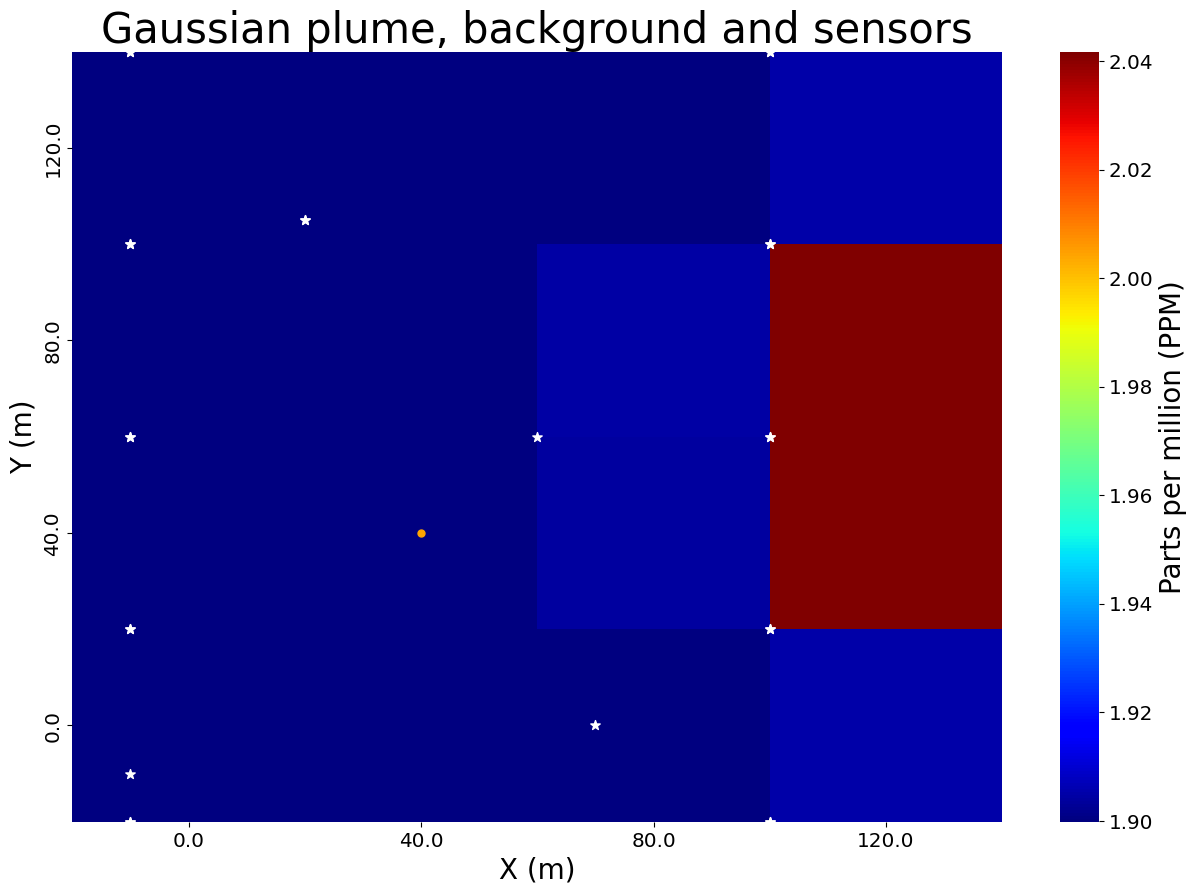

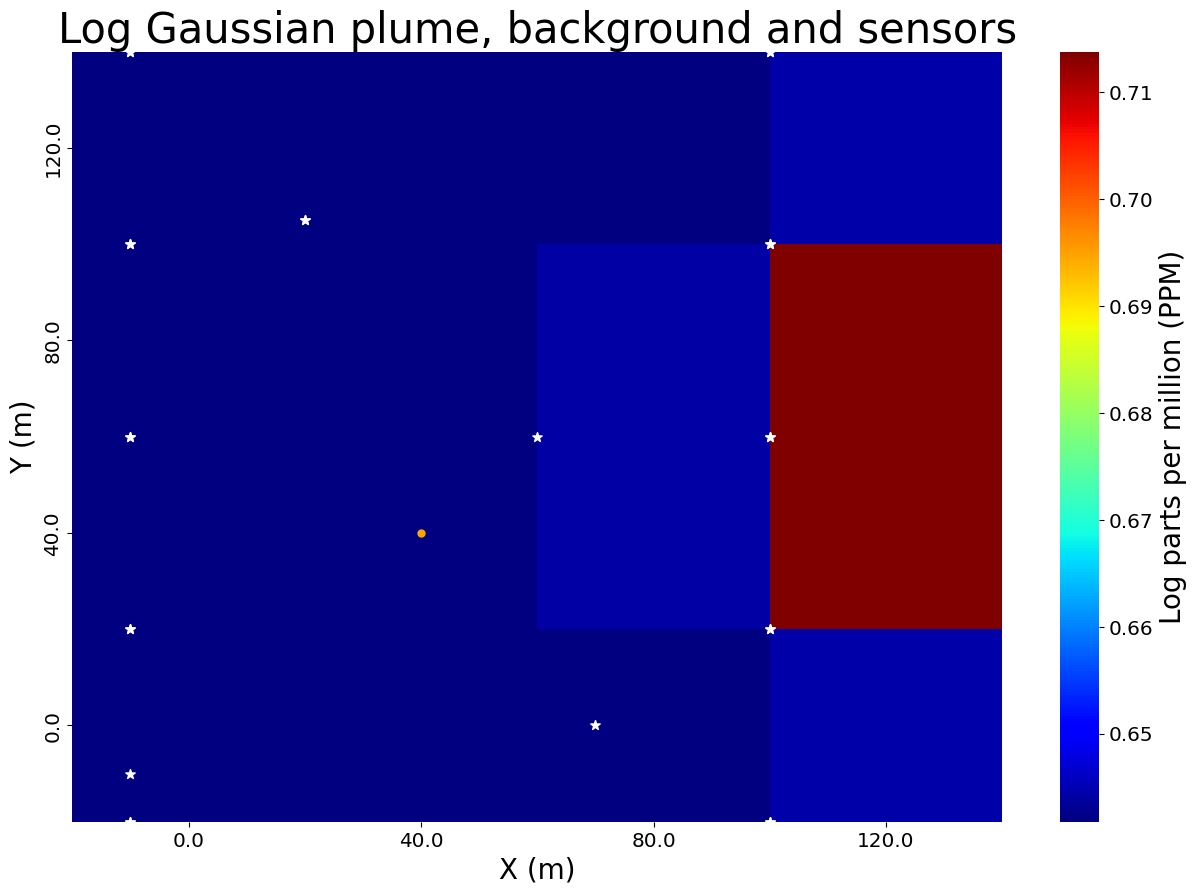

In [7]:
sensors = gp.Sensors(gaussianplume, background)
sensors.atmospheric_methane_and_sensors(save, format='png')
sensors.log_atmospheric_methane_and_sensors(save, format='png')


#### 1.5 Data

In [8]:
truth = sensors.temporal_sensors_measurements()
data = truth[0]
fixed = gaussianplume.fixed_objects_of_grided_coupling_matrix()

priors = mcmc.Priors(
    # slab allocation prior
    theta = 0.1,
    # Original scale SS
    spike_var = 1e-9,
    spike_mean = 0.0,
    slab_var = 1e-6,
    slab_mean = 1.6e-3,
    # Log scale SS
    log_spike_mean = -20.0,
    log_spike_var = 6.0,
    log_slab_mean = -6.5,
    log_slab_var = 5e-1,
    # Sigma squared
    sigma_squared_con = 1.5,
    sigma_squared_rate = 8.0,
    # Background
    mean_log_background_prior = jnp.log(1.9),
    variance_log_background_prior = 5e-2,
    # tan_gamma_H and tan_gamma_V
    tan_gamma_con = jnp.log(0.6),
    tan_gamma_rate = 0.1,
    # b_H and b_V
    b_mean = jnp.log(0.5),
    b_var = 0.1,
)


### 2. ADAM Parameter Estimation

In [9]:
iterations = 25_000

x = {
    'b_H_log': jnp.log(0.6),
    'b_V_log': jnp.log(0.6),
    'background': jnp.full(sensors_settings.sensor_number, 1.9).reshape(-1,1),
    'log_s': jnp.full(16, -8.0).reshape(-1,1),
    'sigma_squared': jnp.array(0.01),
    'tan_gamma_H_log': jnp.log(0.5),
    'tan_gamma_V_log': jnp.log(0.5),
}
x_flat, unflatten = ravel_pytree(x)


In [10]:
def negative_log_posterior(x):
    
    emissions = x["log_s"].reshape(-1,1)
    sigma_squared = x["sigma_squared"]
    betas = jnp.repeat(x["background"], 1_000).reshape(-1,1)
    A = gaussianplume.temporal_grided_coupling_matrix(fixed, jnp.exp(x["tan_gamma_H_log"]), jnp.exp(x["tan_gamma_V_log"]), jnp.exp(x["b_H_log"]), jnp.exp(x["b_V_log"]))

    log_likelihood = tfd.Normal(loc = (jnp.matmul(A,jnp.exp(emissions))+ betas), \
                                scale= jnp.sqrt(sigma_squared)).log_prob(data)
    
    log_prior_tan_gamma_H = tfd.Normal(loc = priors.tan_gamma_con, scale = jnp.sqrt(priors.tan_gamma_rate)).log_prob(x["tan_gamma_H_log"])
    log_prior_tan_gamma_V = tfd.Normal(loc = priors.tan_gamma_con, scale = jnp.sqrt(priors.tan_gamma_rate)).log_prob(x["tan_gamma_V_log"])
    log_prior_b_H = tfd.Normal(loc = priors.b_mean, scale = jnp.sqrt(priors.b_var)).log_prob(x["b_H_log"])
    log_prior_b_V = tfd.Normal(loc = priors.b_mean, scale = jnp.sqrt(priors.b_var)).log_prob(x["b_V_log"])

    log_posterior_emission_rate = tfd.MultivariateNormalDiag(loc = jnp.full(16,-8.0).reshape(-1,1), scale_diag = jnp.sqrt(jnp.full(16,2.0).reshape(-1,1))).log_prob(emissions)
    log_prior_sigma = tfd.Gamma(concentration = priors.sigma_squared_con, rate = priors.sigma_squared_rate).log_prob(sigma_squared)
    log_prior_background = tfd.Normal(loc = 1.9, scale= jnp.sqrt(priors.variance_log_background_prior)).log_prob(x["background"])
    
    log_posterior = jnp.sum(log_likelihood) + jnp.sum(log_prior_tan_gamma_H) + jnp.sum(log_prior_tan_gamma_V) + jnp.sum(log_prior_b_H) + jnp.sum(log_prior_b_V) \
                    + jnp.sum(log_posterior_emission_rate) + jnp.sum(log_prior_sigma) + jnp.sum(log_prior_background)

    return - log_posterior


In [11]:
posi_optimiser_chains = {
    'tan_gamma_H': np.zeros(iterations),
    'tan_gamma_V': np.zeros(iterations),
    'b_H': np.zeros(iterations),
    'b_V': np.zeros(iterations),
    's': np.zeros((iterations, 16)),
    'sigma_squared': np.zeros(iterations),
    'background': np.zeros((iterations, sensors_settings.sensor_number)),
    "loss": np.zeros(iterations),
}


In [12]:
learning_rate = {
    'start_learning_rate' : 1e-3, # 1e-2
    'transition_steps' : 1_000,
    'decay_rate' : 0.99,
    'learning_rate': np.zeros(iterations),
}


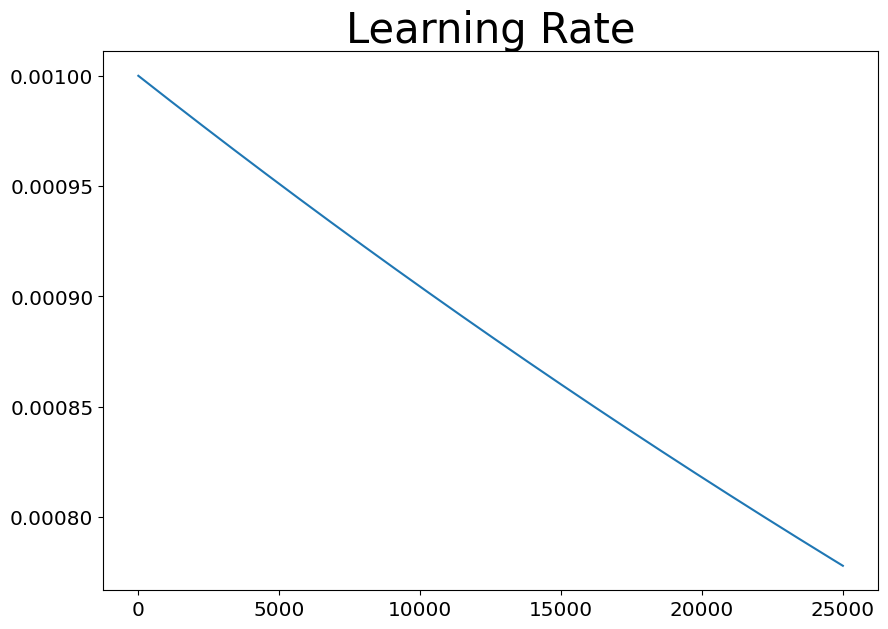

In [13]:
# Exponential decay of the learning rate.
scheduler = optax.exponential_decay(
    init_value = learning_rate["start_learning_rate"], 
    transition_steps = learning_rate["transition_steps"],
    decay_rate = learning_rate["decay_rate"])

for i in range(iterations):
    learning_rate["learning_rate"][i] = learning_rate["start_learning_rate"] * ( learning_rate["decay_rate"] ** (i/learning_rate["transition_steps"]) )

plt.plot(learning_rate["learning_rate"])
plt.title("Learning Rate")
# plt.savefig("Learning Rate.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [14]:
# Combining gradient transforms using `optax.chain`.
gradient_transform = optax.chain(
    optax.clip_by_global_norm(1.0),     # Clip by the gradient by the global norm.
    optax.scale_by_adam(),              # Use the updates from adam.
    optax.scale_by_schedule(scheduler), # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = gradient_transform.init(x)


In [15]:
def step_ADAM(up, index):
    [loss, x, opt_state] = up
    loss, grads = jax.value_and_grad(negative_log_posterior)(x)
    updates, opt_state = gradient_transform.update(grads, opt_state)
    x = optax.apply_updates(x, updates)
    up = [loss, x, opt_state]
    return up, up


def scan_ADAM():
    loss = 0
    _, params = jax.lax.scan(step_ADAM, [loss, x, opt_state], jnp.arange(iterations).reshape(-1,1))
    return params[1], params[0]


In [16]:
tt1 = time.time()
params, loss = scan_ADAM()
tt2 = time.time()
ADAM_time = tt2 - tt1
print("Running time MALA: " + str(round(ADAM_time // 60)) + " minutes " + str(round(ADAM_time % 60)) + " seconds")


Running time MALA: 8 minutes 29 seconds


In [17]:
posi_optimiser_chains = {
    'tan_gamma_H_log': params['tan_gamma_H_log'],
    'tan_gamma_V_log': params['tan_gamma_V_log'],
    'b_H_log': params['b_H_log'],
    'b_V_log': params['b_V_log'],
    'log_s': params['log_s'].squeeze(),
    'sigma_squared': params['sigma_squared'],
    'background':   params['background'].squeeze(),
    "loss": loss,
}



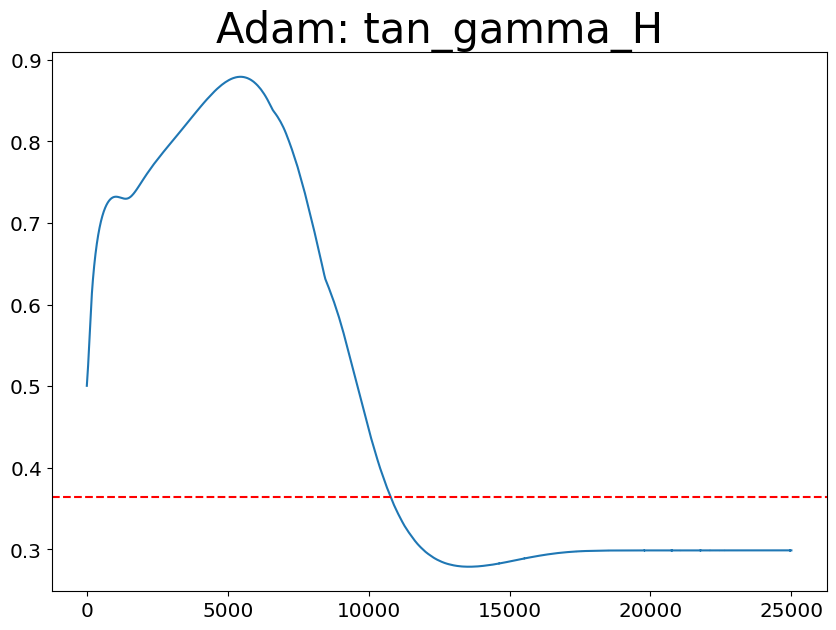

In [18]:
plt.plot(jnp.exp(posi_optimiser_chains['tan_gamma_H_log'][:]))
plt.axhline(jnp.tan(atmospheric_state.horizontal_angle), color='red', linestyle='--', label='True tan_gamma_H')
plt.title("Adam: tan_gamma_H")
# plt.savefig("Adam: tan_gamma_H.pdf", dpi=300, bbox_inches="tight")
plt.show()


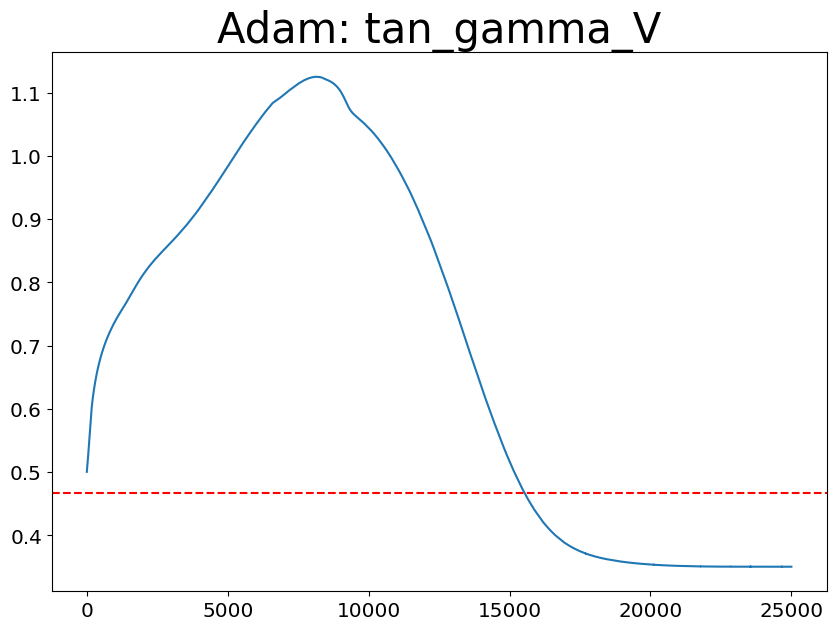

In [19]:
plt.plot(jnp.exp(posi_optimiser_chains['tan_gamma_V_log'][:]))
plt.axhline(jnp.tan(atmospheric_state.vertical_angle), color='red', linestyle='--', label='True tan_gamma_V')
plt.title("Adam: tan_gamma_V")
# plt.savefig("Adam: tan_gamma_V.pdf", dpi=300, bbox_inches="tight")
plt.show()


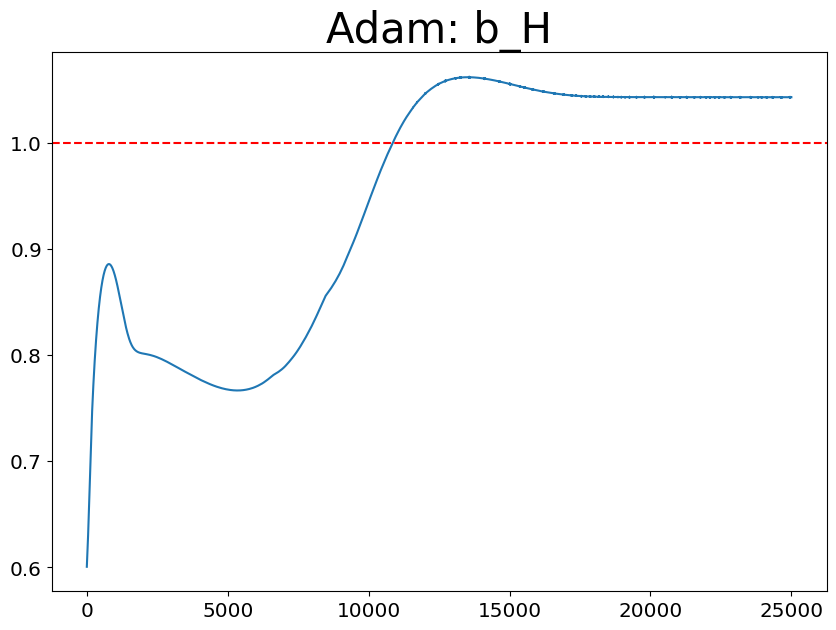

In [20]:
plt.plot(jnp.exp(posi_optimiser_chains['b_H_log'][:]))
plt.axhline(atmospheric_state.downwind_power_H, color='red', linestyle='--', label='True b_H')
plt.title("Adam: b_H")
# plt.savefig("Adam: b_H.pdf", dpi=300, bbox_inches="tight")
plt.show()


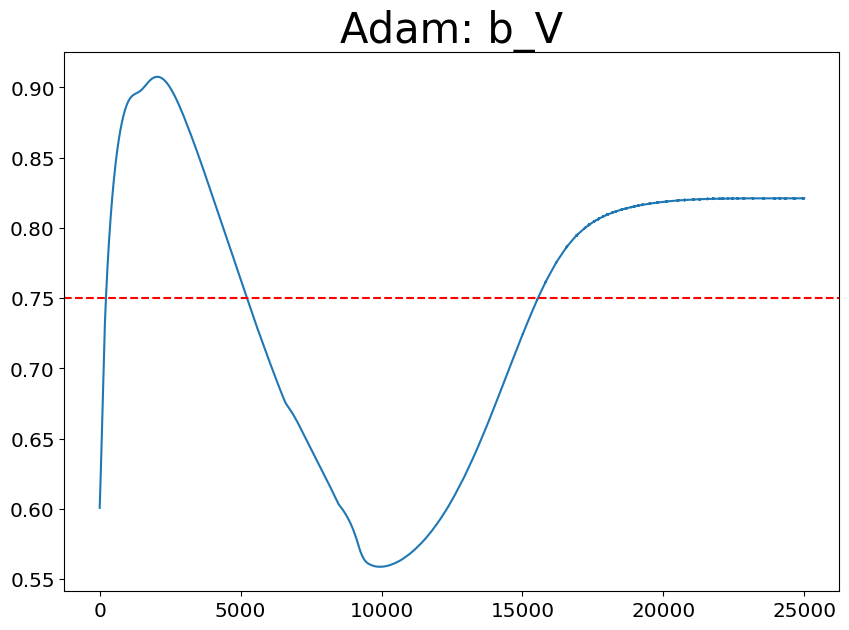

In [21]:
plt.plot(jnp.exp(posi_optimiser_chains['b_V_log'][:]))
plt.axhline(atmospheric_state.downwind_power_V, color='red', linestyle='--', label='True b_V')
plt.title("Adam: b_V")
# plt.savefig("Adam: b_V.pdf", dpi=300, bbox_inches="tight")
plt.show()


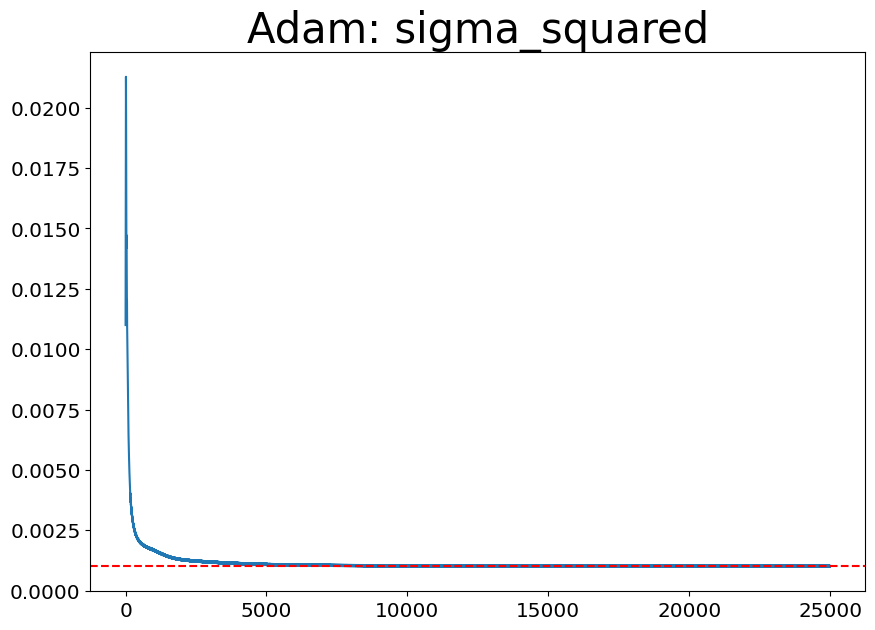

In [22]:
plt.plot(posi_optimiser_chains['sigma_squared'][:])
plt.axhline(sensors_settings.measurement_error_var, color='red', linestyle='--', label='True sigma_squared')
plt.title("Adam: sigma_squared")
# plt.savefig("Adam: sigma_squared.pdf", dpi=300, bbox_inches="tight")
plt.show()


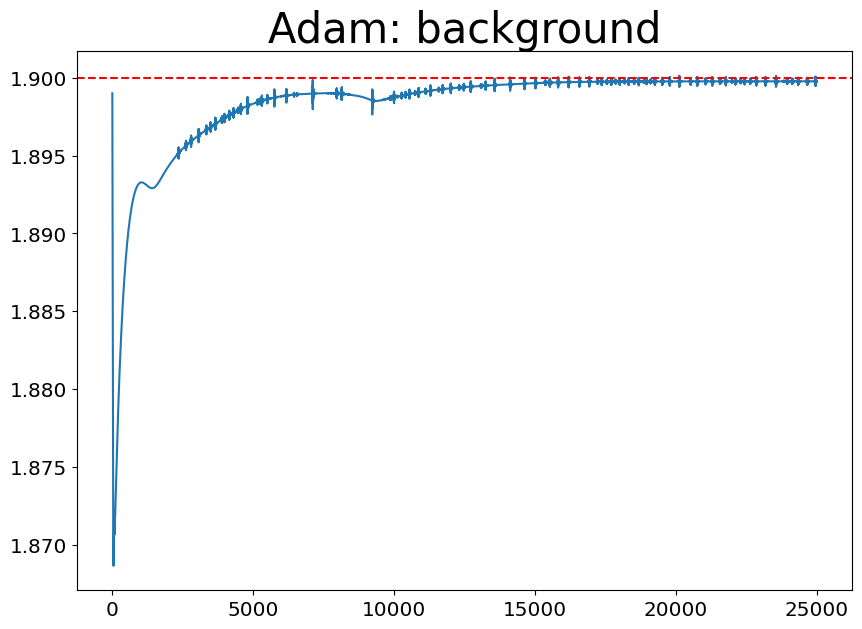

In [23]:
plt.plot(posi_optimiser_chains['background'][:,0])
plt.axhline(atmospheric_state.background_mean, color='red', linestyle='--', label='True background')
plt.title("Adam: background")
# plt.savefig("Adam: background.pdf", dpi=300, bbox_inches="tight")
plt.show()


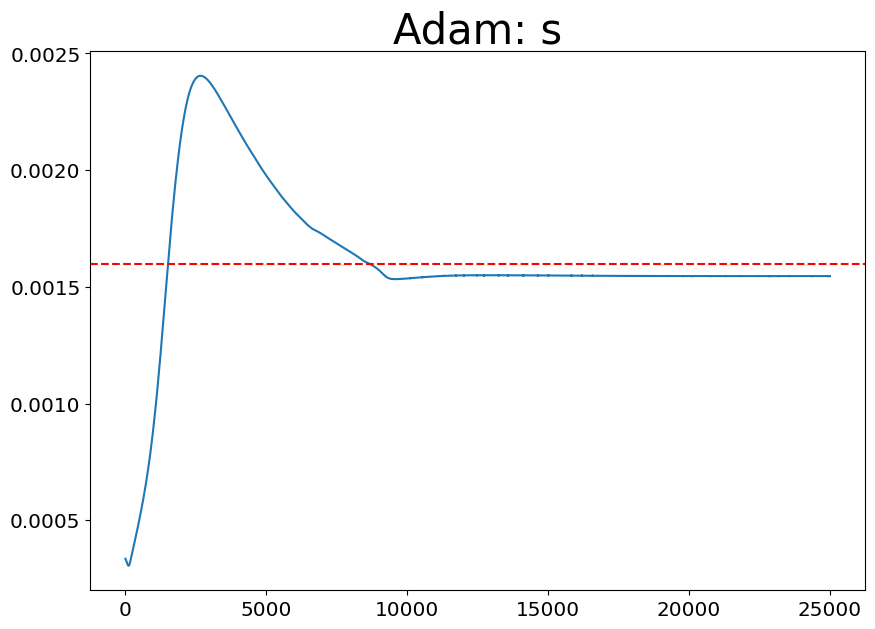

In [24]:

plt.plot(jnp.exp(posi_optimiser_chains['log_s'][:,5]))
plt.axhline(atmospheric_state.emission_rate, color='red', linestyle='--', label='True s')
plt.title("Adam: s")
# plt.savefig("Adam: s.pdf", dpi=300, bbox_inches="tight")
plt.show()


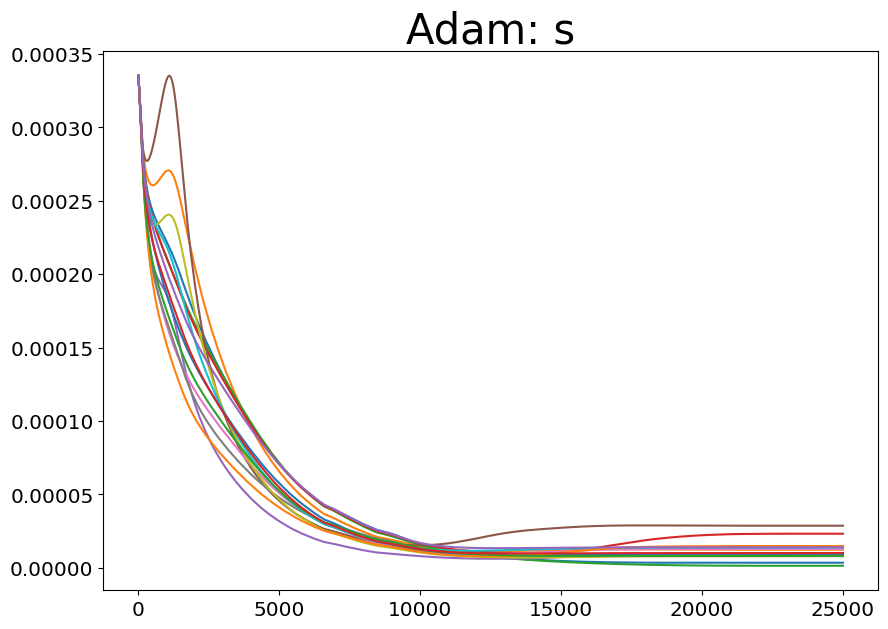

In [25]:

plt.plot(jnp.exp(np.delete(posi_optimiser_chains['log_s'], 5, axis=1))[:])
plt.title("Adam: s")
# plt.savefig("Adam: no s.pdf", dpi=300, bbox_inches="tight")
plt.show()


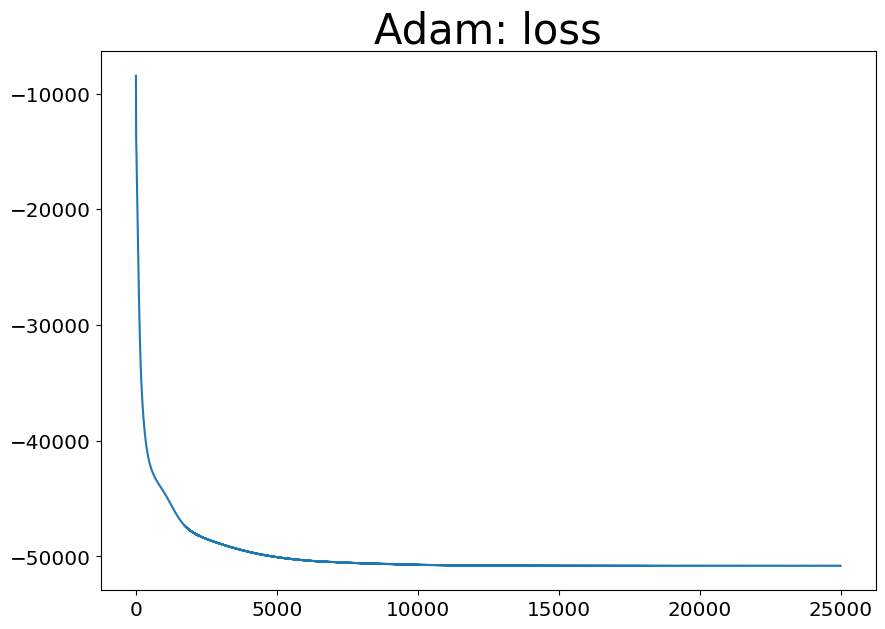

In [26]:

plt.plot(posi_optimiser_chains['loss'][:])
plt.title("Adam: loss")
# plt.savefig("Adam: loss.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [27]:
def calculate_means(chains, start_index):
    return {
        "background": jnp.mean(chains['background'][start_index:,:], axis=0),
        "sigma_squared": jnp.mean(chains['sigma_squared'][start_index:]),
        "log_b_H": jnp.mean(chains['b_H_log'][start_index:]),
        "log_b_V": jnp.mean(chains['b_V_log'][start_index:]),
        "log_s": jnp.mean(chains['log_s'][start_index:,:], axis=0).reshape(-1,1),
        'log_tan_gamma_H': jnp.mean(chains['tan_gamma_H_log'][start_index:]),
        'log_tan_gamma_V': jnp.mean(chains['tan_gamma_V_log'][start_index:]),
    }


In [28]:
mcmc_initialisation = calculate_means(posi_optimiser_chains, 20_000)


with open('mcmc_initialisation_ideal_sensors.pkl', 'wb') as f:
    pickle.dump(mcmc_initialisation, f)

